In [1]:
from pathlib import Path
import sqlite3

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("default")

# figure out project root (works if notebook is in notebooks/)
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DB_PATH = PROJECT_ROOT / "data" / "processed" / "vbb_gtfs.db"
DB_PATH


WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/vbb_gtfs.db')

In [2]:
conn = sqlite3.connect(DB_PATH)

sql = """
SELECT
    d.service_date,
    d.trip_id,
    d.stop_id,
    d.route_id,
    d.planned_arrival,
    d.actual_arrival,
    d.delay_min,
    d.reason,
    r.route_short_name,
    r.route_long_name,
    r.route_type
FROM delays d
LEFT JOIN routes r ON d.route_id = r.route_id;
"""

delays = pd.read_sql_query(sql, conn, parse_dates=["service_date"])
conn.close()

delays.head()


,service_date,trip_id,stop_id,route_id,planned_arrival,actual_arrival,delay_min,reason,route_short_name,route_long_name,route_type
0,2025-11-01,269858095,de:11000:900008101:1:50,10141_109,6:09:00,06:09:00,0,on_time,S1,None,109
1,2025-11-01,269858103,de:11000:900049202:1:50,10141_109,24:00:18,24:05:18,5,connection_wait,S1,None,109
2,2025-11-01,269858113,de:11000:900049201:1:50,10141_109,20:22:24,20:25:24,3,vehicle_late,S1,None,109
3,2025-11-01,269858128,de:11000:900008101:1:50,10141_109,14:49:00,14:53:00,4,connection_wait,S1,None,109
4,2025-11-01,269858134,de:11000:900100007:1:50,10141_109,12:53:42,12:52:42,-1,on_time,S1,None,109


In [3]:
delays.describe(include="all").transpose().head(15)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
service_date,20000,NaN,NaN,NaN,2025-11-01 00:00:00,2025-11-01 00:00:00,2025-11-01 00:00:00,2025-11-01 00:00:00,2025-11-01 00:00:00,2025-11-01 00:00:00,NaN
trip_id,20000.0,NaN,NaN,NaN,277413918.52055,247626653.0,277332307.0,278220660.0,278597612.5,278924854.0,2542212.372278
stop_id,20000,8964,de:11000:900023201::5,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route_id,20000,1061,17449_700,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
planned_arrival,20000,3476,16:03:00,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
actual_arrival,20000,3497,14:47:00,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delay_min,20000.0,NaN,NaN,NaN,1.8459,-5.0,0.0,1.0,3.0,20.0,4.222031
reason,20000,7,on_time,11939,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route_short_name,20000,835,M29,286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route_long_name,4,1,PlusBus Nationalparklinie,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
n_events = len(delays)
avg_delay = delays["delay_min"].mean()
share_over_5 = (delays["delay_min"] > 5).mean()
share_on_time_or_early = (delays["delay_min"] <= 0).mean()

summary = pd.DataFrame(
    {
        "metric": [
            "n_delay_events",
            "avg_delay_min",
            "share_over_5min",
            "share_on_time_or_early",
        ],
        "value": [
            n_events,
            avg_delay,
            share_over_5,
            share_on_time_or_early,
        ],
    }
)
summary


,metric,value
0,n_delay_events,20000.00000
1,avg_delay_min,1.84590
2,share_over_5min,0.09240
3,share_on_time_or_early,0.45865


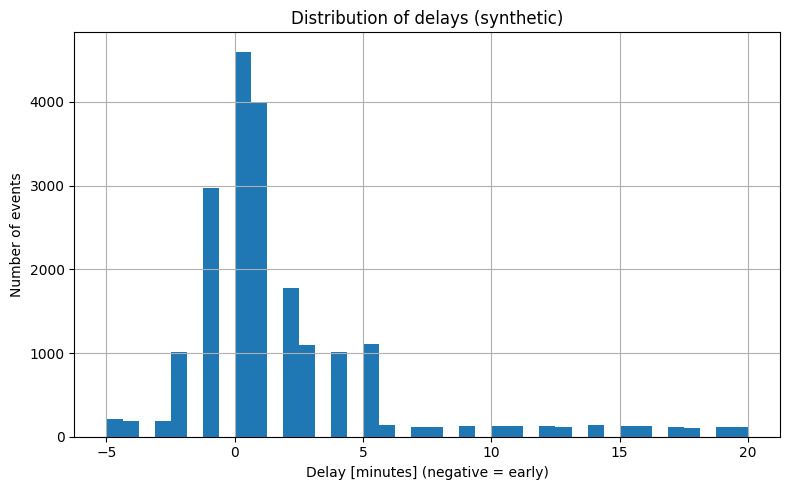

In [5]:
plt.figure(figsize=(8, 5))
delays["delay_min"].hist(bins=40)
plt.xlabel("Delay [minutes] (negative = early)")
plt.ylabel("Number of events")
plt.title("Distribution of delays (synthetic)")
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

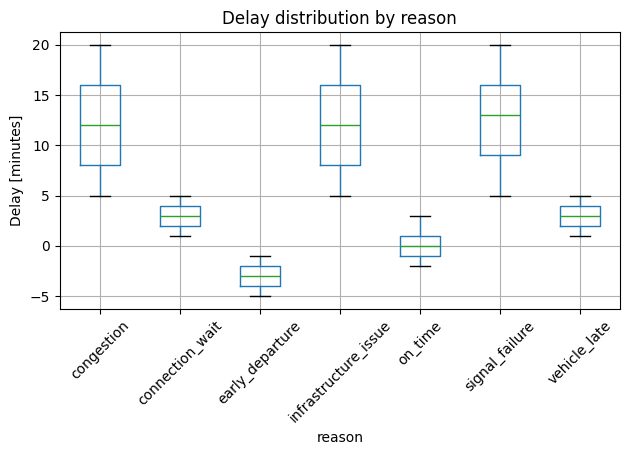

In [6]:
plt.figure(figsize=(10, 5))
delays.boxplot(column="delay_min", by="reason", rot=45)
plt.ylabel("Delay [minutes]")
plt.title("Delay distribution by reason")
plt.suptitle("")  # remove default
plt.tight_layout()
plt.show()


In [7]:
route_kpis = (
    delays.groupby(["route_id", "route_short_name", "route_long_name"])
    .agg(
        n_events=("delay_min", "size"),
        avg_delay_min=("delay_min", "mean"),
        share_over_5min=("delay_min", lambda x: (x > 5).mean()),
        share_on_time_or_early=("delay_min", lambda x: (x <= 0).mean()),
    )
    .reset_index()
)

route_kpis.head()


,route_id,route_short_name,route_long_name,n_events,avg_delay_min,share_over_5min,share_on_time_or_early
0,19118_700,468,PlusBus Nationalparklinie,4,1.0,0.0,0.5


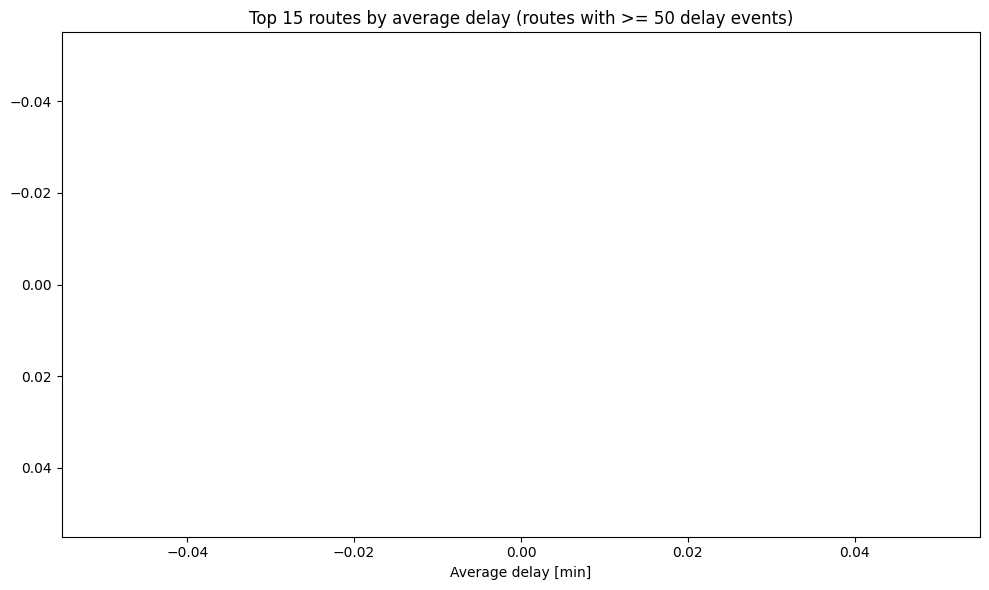

,route_id,route_short_name,route_long_name,n_events,avg_delay_min,share_over_5min,share_on_time_or_early


In [8]:
top_worst_avg = (
    route_kpis[route_kpis["n_events"] >= 50]  # filter to avoid tiny sample routes
    .sort_values("avg_delay_min", ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
labels = top_worst_avg["route_short_name"].fillna(top_worst_avg["route_id"].astype(str))
plt.barh(labels, top_worst_avg["avg_delay_min"])
plt.xlabel("Average delay [min]")
plt.title("Top 15 routes by average delay (routes with >= 50 delay events)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

top_worst_avg


In [9]:
# No filtering by n_events here – we want something to analyze even with small samples
top_worst_avg = (
    route_kpis
    .sort_values("avg_delay_min", ascending=False)
    .head(15)
)

top_worst_share5 = (
    route_kpis
    .sort_values("share_over_5min", ascending=False)
    .head(15)
)

print("Top worst routes by average delay (head):")
display(top_worst_avg.head())

print("Top worst routes by severe delay share (head):")
display(top_worst_share5.head())



Top worst routes by average delay (head):


,route_id,route_short_name,route_long_name,n_events,avg_delay_min,share_over_5min,share_on_time_or_early
0,19118_700,468,PlusBus Nationalparklinie,4,1.0,0.0,0.5


Top worst routes by severe delay share (head):


,route_id,route_short_name,route_long_name,n_events,avg_delay_min,share_over_5min,share_on_time_or_early
0,19118_700,468,PlusBus Nationalparklinie,4,1.0,0.0,0.5


In [10]:
def extract_hour(t_str: str) -> int:
    # GTFS can have hour >= 24, but that's fine
    h = int(str(t_str).split(":")[0])
    return h

delays["hour"] = delays["planned_arrival"].apply(extract_hour)

hour_kpis = (
    delays.groupby("hour")["delay_min"]
    .agg(
        n_events="size",
        avg_delay_min="mean",
        share_over_5min=lambda x: (x > 5).mean(),
    )
    .reset_index()
)

hour_kpis


,hour,n_events,avg_delay_min,share_over_5min
0,0,4,3.000000,0.000000
1,1,13,2.615385,0.153846
2,2,8,0.875000,0.125000
3,3,90,1.788889,0.100000
4,4,279,1.913978,0.100358
5,5,590,1.655932,0.089831
6,6,921,1.874050,0.093377
7,7,1060,1.876415,0.092453
8,8,990,1.736364,0.082828
9,9,1126,1.912966,0.102131


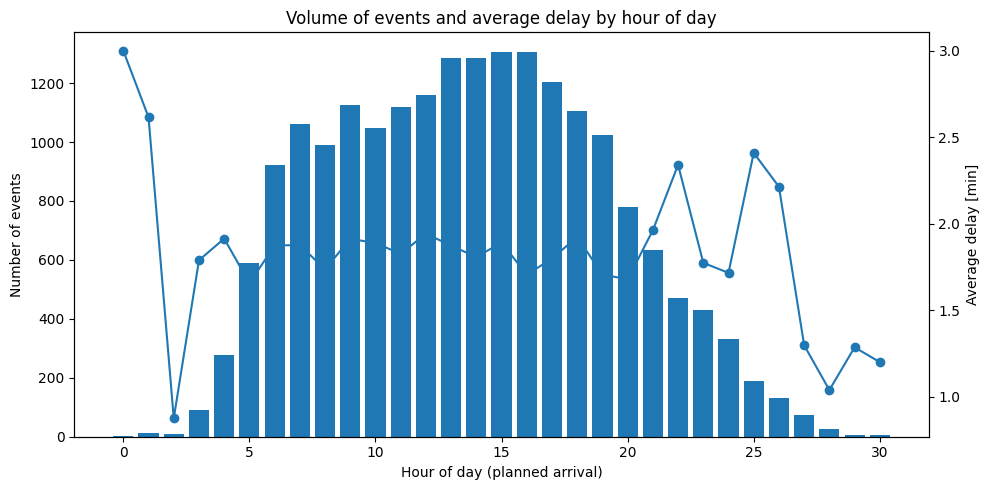

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(hour_kpis["hour"], hour_kpis["n_events"])
ax1.set_xlabel("Hour of day (planned arrival)")
ax1.set_ylabel("Number of events")

ax2 = ax1.twinx()
ax2.plot(hour_kpis["hour"], hour_kpis["avg_delay_min"], marker="o")
ax2.set_ylabel("Average delay [min]")

plt.title("Volume of events and average delay by hour of day")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd  # safe even if already imported

summary_points = []

# 1) Worst route by average delay (if available)
if not top_worst_avg.empty:
    worst_route_avg = top_worst_avg.iloc[0]
    route_label_avg = (
        worst_route_avg["route_short_name"]
        if pd.notna(worst_route_avg["route_short_name"])
        else str(worst_route_avg["route_id"])
    )
    summary_points.append(
        f"Route {route_label_avg} has the highest average delay: "
        f"{worst_route_avg['avg_delay_min']:.1f} minutes "
        f"across {int(worst_route_avg['n_events'])} recorded delay events."
    )
else:
    summary_points.append(
        "No route has enough delay events for a stable average delay statistic in this sample."
    )

# 2) Worst route by share of severe delays > 5 min (if available)
if not top_worst_share5.empty:
    worst_route_share5 = top_worst_share5.iloc[0]
    route_label_share = (
        worst_route_share5["route_short_name"]
        if pd.notna(worst_route_share5["route_short_name"])
        else str(worst_route_share5["route_id"])
    )
    summary_points.append(
        f"Route {route_label_share} shows the highest share of severe delays (>5 min): "
        f"{worst_route_share5['share_over_5min']:.1%}."
    )
else:
    summary_points.append(
        "No route has enough delay events to compute a stable severe-delay share (>5 min)."
    )

# 3) Worst hour of day by average delay (if available)
if not hour_kpis.empty:
    peak_hour = hour_kpis.sort_values("avg_delay_min", ascending=False).iloc[0]
    summary_points.append(
        f"The highest average delay occurs around hour {int(peak_hour['hour'])}: "
        f"{peak_hour['avg_delay_min']:.1f} minutes on average."
    )
else:
    summary_points.append(
        "No hour-of-day delay statistics available in the current dataset."
    )

summary_points



['Route 468 has the highest average delay: 1.0 minutes across 4 recorded delay events.',
 'Route 468 shows the highest share of severe delays (>5 min): 0.0%.',
 'The highest average delay occurs around hour 0: 3.0 minutes on average.']

In [13]:
# Export route- and hour-level delay KPIs for later use (Power BI, reports, etc.)

# 1) Add a simple impact score for each route:
#    impact_score = max(avg_delay, 0) * number of events
route_kpis_export = route_kpis.copy()
route_kpis_export["impact_score"] = (
    route_kpis_export["avg_delay_min"].clip(lower=0) * route_kpis_export["n_events"]
)

# Save route KPIs
route_kpis_path = PROJECT_ROOT / "data" / "processed" / "route_delay_kpis.csv"
route_kpis_export.to_csv(route_kpis_path, index=False)

# Save hour-of-day KPIs
hour_kpis_path = PROJECT_ROOT / "data" / "processed" / "hour_delay_kpis.csv"
hour_kpis.to_csv(hour_kpis_path, index=False)

route_kpis_path, hour_kpis_path


(WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/route_delay_kpis.csv'),
 WindowsPath('C:/Users/devra/germany-public-transport-analytics/data/processed/hour_delay_kpis.csv'))